## Setup

In [1]:
# tensorflow backend
print('tensorflow backend')
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
print('vae stuff')
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
print('iport scientific py')
import numpy as np
import pandas as pd
# rdkit stuff
print('rdkit stuff')
from rdkit.Chem import AllChem as Chem
# plotting stuff
print('plotting stuff')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

tensorflow backend
vae stuff


Using TensorFlow backend.
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packag

iport scientific py
rdkit stuff
plotting stuff


## Fetch SMIELS data

In [2]:
df = pd.read_csv('./data/aryl_ether/aryl_ether.csv')
df['index'] = list(range(len(df)))
aryl_ether_smiles =  df[['index', 'annotation_reference', 'smiles']].values.tolist()
print('data fetched:', len(aryl_ether_smiles))

data fetched: 1827


In [9]:
aryl_ether_smiles[1820]

[1820,
 'imgf000116_0002.tif',
 'OCC1=C(C=CC(OC2=CC=CC(=C2)C#N)=C1Cl)S(=O)(=O)C(F)F']

## Load a model

In [3]:
vae = VAEUtils(directory='models/zinc_properties')

From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1156: calling reduce_max (from tensorflow.python.ops.mat

Using standarized functions? True
Standarization: estimating mu and std values ...done!


## Decode latent space / fingerprint

In [43]:
# bytes to bits
def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] & (1<<shift)) >> shift

def smiles_to_vect(smiles_group):
    denied_count = 0
    index = list(range(len(smiles_group)))
    print('index:', len(index))
    smiles_list = []
    for idx, data in enumerate(smiles_group):
        if('.' in data[2]):
            denied_count += 1
            index.remove(data[0])
            continue
        try:
            smiles_list.append([idx, mu.canon_smiles(data[2])])
        except:
            denied_count += 1
            index.remove(data[0])
    print(denied_count, 'smiles denied')
    fp_index = index

    df = pd.DataFrame(fp_index)
    df.to_csv('./data/aryl_ether/fp_index.csv')

    # latent spcae
    print('(1/5) encoding latent space...')
    # Xs = [ (vae.smiles_to_hot(smiles, canonize_smiles=True)) for smiles in smiles_list ]
    Xs = []
    
    print('index:', len(index))
    denied_count = 0
    for idx, smiles in enumerate(smiles_list):
        try:
            Xs.append([smiles[0], vae.smiles_to_hot(smiles[1], canonize_smiles=True)])
        except:
            denied_count += 1
            index.remove(smiles[0])
    print(denied_count, 'smiles denied')
    print('index:', len(index))

    # Zs = [ list(vae.encode(X)[0]) for X in Xs ]
    Zs = []
    denied_count = 0
    for idx, X in enumerate(Xs):
        try:
            Zs.append(list(vae.encode(X[1])[0]))
        except:
            denied_count += 1
            index.remove(X[0])
    print(denied_count, 'smiles denied')
    print('index:', len(index))

    df = pd.DataFrame(index)
    df.to_csv('./data/aryl_ether/index.csv')

    latent_group.extend(list(zip(Zs, [ data[1] for data in smiles_group ])))
    
    mols = [ Chem.MolFromSmiles(smiles) for smiles in [ smiles[1] for smiles in smiles_list ] ]

    # rdk fp
    print('\r(2/5) encoding rdk fp...')
    fps = [ Chem.RDKFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    rdk_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

    # pattern fp
    print('\r(3/5) encoding pattern fp...')
    fps = [ Chem.PatternFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    pattern_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

    # layered fp
    print('\r(4/5) encoding layered fp...')
    fps = [ Chem.LayeredFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    layered_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

    # MACCSKeys fp
    print('\r(5/5) encoding layered fp...')
    fps = [ Chem.GetMACCSKeysFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    MACCSKeys_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

## Convert smiles to coordinates

In [44]:
latent_smiles = []
fingerprint_smiles = []
latent_group = []
rdk_fp_group = []
pattern_fp_group = []
layered_fp_group = []
MACCSKeys_fp_group = []
smiles_to_vect(aryl_ether_smiles)

index: 1827
183 smiles denied
(1/5) encoding latent space...
index: 1644
61 smiles denied
index: 1583
5 smiles denied
index: 1578
(2/5) encoding rdk fp...
(3/5) encoding pattern fp...
(4/5) encoding layered fp...
(5/5) encoding layered fp...


## Save latent/fingerprint data

In [60]:
df = pd.DataFrame(latent_group)
df.to_csv('./data/aryl_ether/latent_group.csv')

df = pd.DataFrame(rdk_fp_group)
df.to_csv('./data/aryl_ether/rdk_fp_group.csv')

df = pd.DataFrame(pattern_fp_group)
df.to_csv('./data/aryl_ether/pattern_fp_group.csv')

df = pd.DataFrame(layered_fp_group)
df.to_csv('./data/aryl_ether/layered_fp_group.csv')

df = pd.DataFrame(MACCSKeys_fp_group)
df.to_csv('./data/aryl_ether/MACCSKeys_fp_group.csv')

## Load latent/fingerprint data

In [30]:
print('(1/5) fetching latent space group...')
latent_group = []
df = pd.read_csv('./data/aryl_ether/latent_group.csv')
for i in range(len(df)):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    latent_group.append(points)

print('(2/5) fetching rdk fp group...')
rdk_fp_group = []
df = pd.read_csv('./data/aryl_ether/rdk_fp_group.csv')
for i in range(len(df)):
    points = list(map(int, df.loc[i, '0'].strip('[]').split(', ')))
    rdk_fp_group.append(points)

print('(3/5) fetching pattern fp group...')
pattern_fp_group = []
df = pd.read_csv('./data/aryl_ether/pattern_fp_group.csv')
for i in range(len(df)):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    pattern_fp_group.append(points)

print('(4/5) fetching layered fp group...')
layered_fp_group = []
df = pd.read_csv('./data/aryl_ether/layered_fp_group.csv')
for i in range(len(df)):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    layered_fp_group.append(points)


print('(5/5) fetching MACCSKeys fp group...')
MACCSKeys_fp_group = []
df = pd.read_csv('./data/aryl_ether/MACCSKeys_fp_group.csv')
for i in range(len(df)):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    MACCSKeys_fp_group.append(points)

(1/5) fetching latent space group...
(2/5) fetching rdk fp group...
(3/5) fetching pattern fp group...
(4/5) fetching layered fp group...
(5/5) fetching MACCSKeys fp group...


## Build DimReduction Model

In [84]:
n_components = 2
model_pca = PCA(n_components=n_components)
model_tsne = TSNE(n_components=n_components)

## Train and save DimReduction Model

In [91]:
print('\r(1/10) {:30s}'.format('training latent tsne...'))
points_latent_tsne = model_tsne.fit_transform([ points for points in latent_group ])
df = pd.DataFrame(points_latent_tsne)
df.to_csv('./data/aryl_ether/points_latent_tsne.csv')

print('\r(2/10) {:30s}'.format('training latent pca...'))
points_latent_pca = model_pca.fit_transform([ points for points in latent_group ])
df = pd.DataFrame(points_latent_pca)
df.to_csv('./data/aryl_ether/points_latent_pca.csv')

print('\r(3/10) {:30s}'.format('training rdk fingerprint tsne...'))
points_rdk_fp_tsne = model_tsne.fit_transform([ points for points in rdk_fp_group ])
df = pd.DataFrame(points_rdk_fp_tsne)
df.to_csv('./data/aryl_ether/points_rdk_fp_tsne.csv')


print('\r(4/10) {:30s}'.format('training rdk fingerprint pca...'))
points_rdk_fp_pca = model_pca.fit_transform([ points for points in rdk_fp_group ])
df = pd.DataFrame(points_rdk_fp_pca)
df.to_csv('./data/aryl_ether/points_rdk_fp_pca.csv')

print('\r(5/10) {:30s}'.format('training pattern fingerprint tsne...'))
points_pattern_fp_tsne = model_tsne.fit_transform([ points for points in pattern_fp_group ])
df = pd.DataFrame(points_pattern_fp_tsne)
df.to_csv('./data/aryl_ether/points_pattern_fp_tsne.csv')

print('\r(6/10) {:30s}'.format('training pattern fingerprint pca...'))
points_pattern_fp_pca = model_pca.fit_transform([ points for points in pattern_fp_group ])
df = pd.DataFrame(points_pattern_fp_pca)
df.to_csv('./data/aryl_ether/points_pattern_fp_pca.csv')

print('\r(7/10) {:30s}'.format('training layered fingerprint tsne...'))
points_layered_fp_tsne = model_tsne.fit_transform([ points for points in layered_fp_group ])
df = pd.DataFrame(points_layered_fp_tsne)
df.to_csv('./data/aryl_ether/points_layered_fp_tsne.csv')

print('\r(8/10) {:30s}'.format('training layered fingerprint pca...'))
points_layered_fp_pca = model_pca.fit_transform([ points for points in layered_fp_group ])
df = pd.DataFrame(points_layered_fp_pca)
df.to_csv('./data/aryl_ether/points_layered_fp_pca.csv')

print('\r(9/10) {:30s}'.format('training MACCSKeys fingerprint tsne...'))
points_MACCSKeys_fp_tsne = model_tsne.fit_transform([ points for points in MACCSKeys_fp_group ])
df = pd.DataFrame(points_MACCSKeys_fp_tsne)
df.to_csv('./data/aryl_ether/points_MACCSKeys_fp_tsne.csv')

print('\r(10/10) {:30s}'.format('training MACCSKeys fingerprint pca...'))
points_MACCSKeys_fp_pca = model_pca.fit_transform([ points for points in MACCSKeys_fp_group ])
df = pd.DataFrame(points_MACCSKeys_fp_pca)
df.to_csv('./data/aryl_ether/points_MACCSKeys_fp_pca.csv')

# Takes about 12000s.

(1/10) training latent tsne...       
(2/10) training latent pca...        
(3/10) training rdk fingerprint tsne...
(4/10) training rdk fingerprint pca...
(5/10) training pattern fingerprint tsne...
(6/10) training pattern fingerprint pca...
(7/10) training layered fingerprint tsne...
(8/10) training layered fingerprint pca...
(9/10) training MACCSKeys fingerprint tsne...
(10/10) training MACCSKeys fingerprint pca...


## Load coordinates

In [31]:
import pandas as pd
from matplotlib import pyplot as plt

In [32]:
print('(0/10) fetching latent space group...')
latent_group = []
df = pd.read_csv('./data/aryl_ether/latent_group.csv')
for i in range(len(df)):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    latent_group.append(points)

print('(1/10) fetching latent space tsne points...')
points_latent_tsne = []
df = pd.read_csv('./data/aryl_ether/points_latent_tsne.csv')
for i in range(len(df)):\
    points_latent_tsne.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))

print('(2/10) fetching latent space pca points...')
points_latent_pca = []
df = pd.read_csv('./data/aryl_ether/points_latent_pca.csv')
for i in range(len(df)):
    points_latent_pca.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))

print('(3/10) fetching rdk fingerprint tsne points...')
points_rdk_fp_tsne = []
df = pd.read_csv('./data/aryl_ether/points_rdk_fp_tsne.csv')
for i in range(len(df)):
    points_rdk_fp_tsne.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))
    
print('(4/10) fetching rdk fingerprint pca points...')
points_rdk_fp_pca = []
df = pd.read_csv('./data/aryl_ether/points_rdk_fp_pca.csv')
for i in range(len(df)):
    points_rdk_fp_pca.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))

print('(5/10) fetching pattern fingerprint tsne points...')
points_pattern_fp_tsne = []
df = pd.read_csv('./data/aryl_ether/points_pattern_fp_tsne.csv')
for i in range(len(df)):
    points_pattern_fp_tsne.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))
    
print('(6/10) fetching pattern fingerprint pca points...')
points_pattern_fp_pca = []
df = pd.read_csv('./data/aryl_ether/points_pattern_fp_pca.csv')
for i in range(len(df)):
    points_pattern_fp_pca.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))

print('(7/10) fetching layered fingerprint tsne points...')
points_layered_fp_tsne = []
df = pd.read_csv('./data/aryl_ether/points_layered_fp_tsne.csv')
for i in range(len(df)):
    points_layered_fp_tsne.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))
    
print('(8/10) fetching layered fingerprint pca points...')
points_layered_fp_pca = []
df = pd.read_csv('./data/aryl_ether/points_layered_fp_pca.csv')
for i in range(len(df)):
    points_layered_fp_pca.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))

print('(9/10) fetching MACCSKeys fingerprint tsne points...')
points_MACCSKeys_fp_tsne = []
df = pd.read_csv('./data/aryl_ether/points_MACCSKeys_fp_tsne.csv')
for i in range(len(df)):
    points_MACCSKeys_fp_tsne.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))
    
print('(10/10) fetching MACCSKeys fingerprint pca points...')
points_MACCSKeys_fp_pca = []
df = pd.read_csv('./data/aryl_ether/points_MACCSKeys_fp_pca.csv')
for i in range(len(df)):
    points_MACCSKeys_fp_pca.append(list(map(float, [df.loc[i, '0'], df.loc[i, '1']])))

(0/10) fetching latent space group...
(1/10) fetching latent space tsne points...
(2/10) fetching latent space pca points...
(3/10) fetching rdk fingerprint tsne points...
(4/10) fetching rdk fingerprint pca points...
(5/10) fetching pattern fingerprint tsne points...
(6/10) fetching pattern fingerprint pca points...
(7/10) fetching layered fingerprint tsne points...
(8/10) fetching layered fingerprint pca points...
(9/10) fetching MACCSKeys fingerprint tsne points...
(10/10) fetching MACCSKeys fingerprint pca points...


## Visualize the data

1578 1650 1650


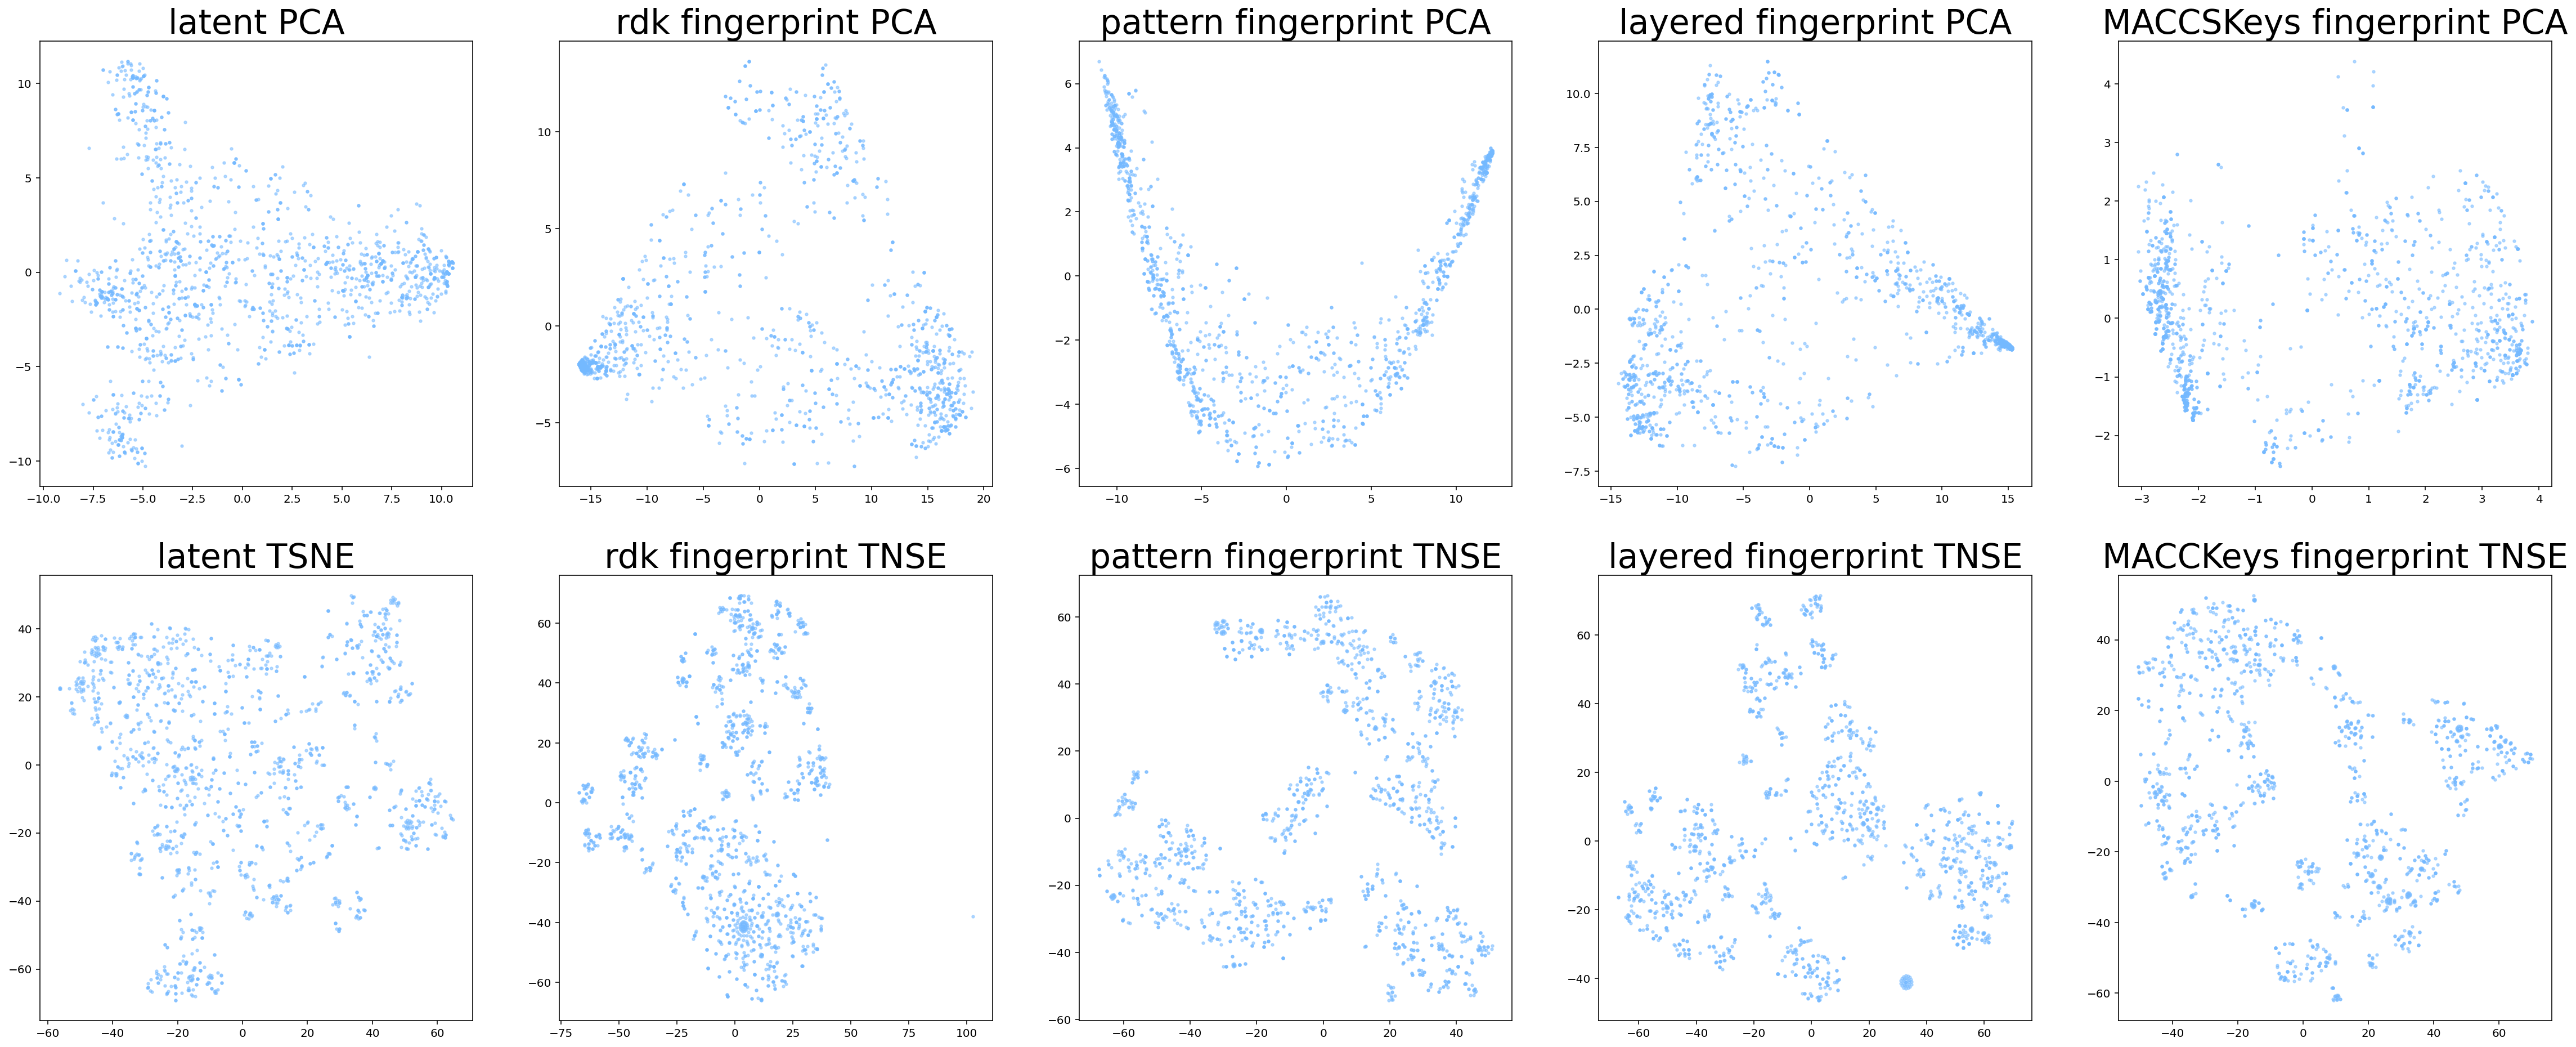

In [33]:
x1 = [ point[0] for point in points_latent_pca ]
y1 = [ point[1] for point in points_latent_pca ]

x2 = [ point[0] for point in points_latent_tsne ]
y2 = [ point[1] for point in points_latent_tsne ]

x3 = [ point[0] for point in points_rdk_fp_pca ]
y3 = [ point[1] for point in points_rdk_fp_pca ]

x4 = [ point[0] for point in points_rdk_fp_tsne ]
y4 = [ point[1] for point in points_rdk_fp_tsne ]

x5 = [ point[0] for point in points_pattern_fp_pca ]
y5 = [ point[1] for point in points_pattern_fp_pca ]

x6 = [ point[0] for point in points_pattern_fp_tsne ]
y6 = [ point[1] for point in points_pattern_fp_tsne ]

x7 = [ point[0] for point in points_layered_fp_pca ]
y7 = [ point[1] for point in points_layered_fp_pca ]

x8 = [ point[0] for point in points_layered_fp_tsne ]
y8 = [ point[1] for point in points_layered_fp_tsne ]

x9 = [ point[0] for point in points_MACCSKeys_fp_pca ]
y9 = [ point[1] for point in points_MACCSKeys_fp_pca ]

x10 = [ point[0] for point in points_MACCSKeys_fp_tsne ]
y10 = [ point[1] for point in points_MACCSKeys_fp_tsne ]

print(len(x1), len(x3), len(x5))

alpha = 0.5
size = 5
color = '#74b9ff'
bg_color = '#ffffff' # '#CAD3C8'
fontsize = 30

cmap = plt.cm.get_cmap('cool', 2)

fig, ax = plt.subplots(5, 2)
fig.set_size_inches((40, 16))
plt.rcParams['axes.facecolor'] = bg_color
plt.subplot(251)
plt.scatter(x1, y1, c=color, s=size, alpha=alpha)
plt.title('latent PCA', fontsize=fontsize)

plt.subplot(256)
plt.scatter(x2, y2, c=color, s=size, alpha=alpha)
plt.title('latent TSNE', fontsize=fontsize)

plt.subplot(252)
plt.scatter(x3, y3, c=color, s=size, alpha=alpha)
plt.title('rdk fingerprint PCA', fontsize=fontsize)

plt.subplot(257)
plt.scatter(x4, y4, c=color, s=size, alpha=alpha)
plt.title('rdk fingerprint TNSE', fontsize=fontsize)

plt.subplot(253)
plt.scatter(x5, y5, c=color, s=size, alpha=alpha)
plt.title('pattern fingerprint PCA', fontsize=fontsize)

plt.subplot(258)
plt.scatter(x6, y6, c=color, s=size, alpha=alpha)
plt.title('pattern fingerprint TNSE', fontsize=fontsize)

plt.subplot(254)
plt.scatter(x7, y7, c=color, s=size, alpha=alpha)
plt.title('layered fingerprint PCA', fontsize=fontsize)

plt.subplot(259)
plt.scatter(x8, y8, c=color, s=size, alpha=alpha)
plt.title('layered fingerprint TNSE', fontsize=fontsize)

plt.subplot(255)
plt.scatter(x9, y9, c=color, s=size, alpha=alpha)
plt.title('MACCSKeys fingerprint PCA', fontsize=fontsize)

plt.subplot(2, 5,10)
plt.scatter(x10, y10, c=color, s=size, alpha=alpha)
plt.title('MACCKeys fingerprint TNSE', fontsize=fontsize)

plt.show()

## K means clustering - latent space

data fetched: 1827


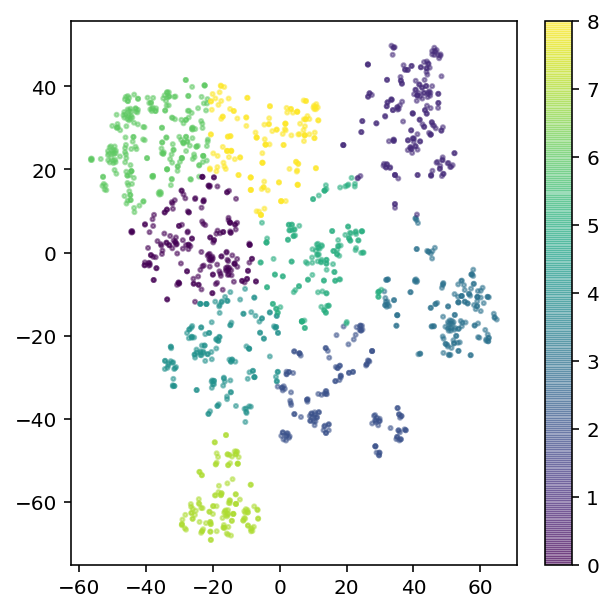

<< label 0 >>


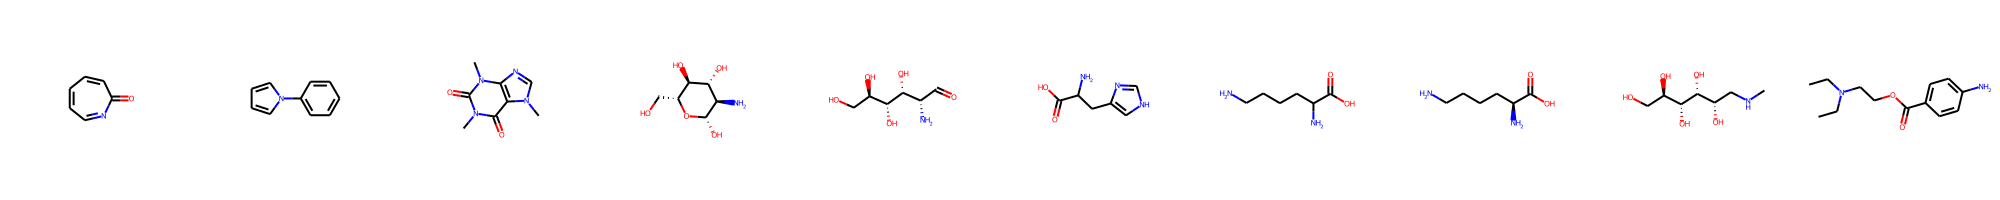

<< label 1 >>


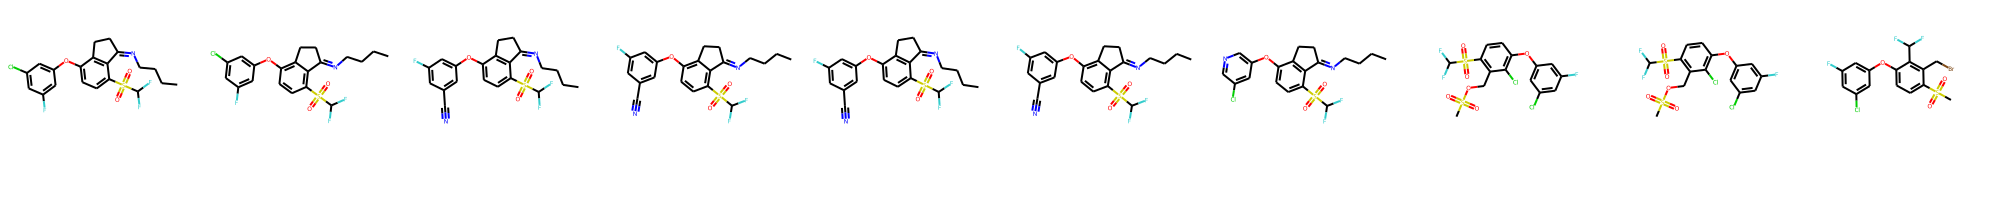

<< label 2 >>


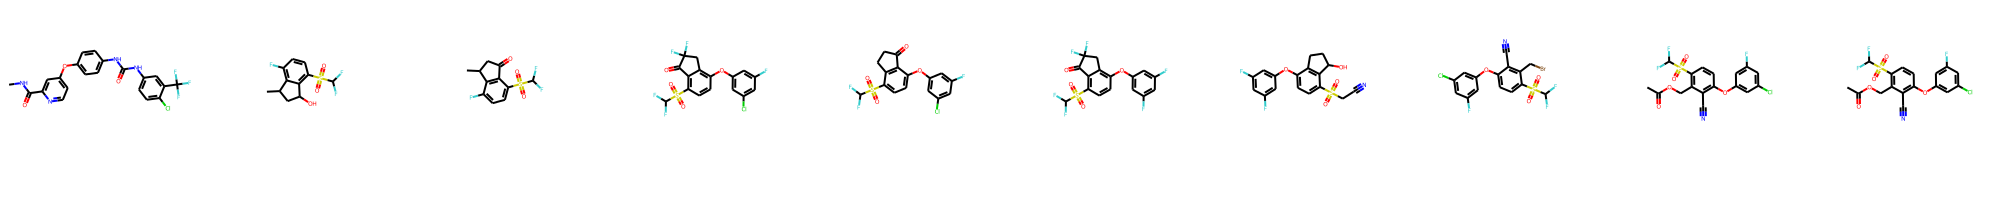

<< label 3 >>


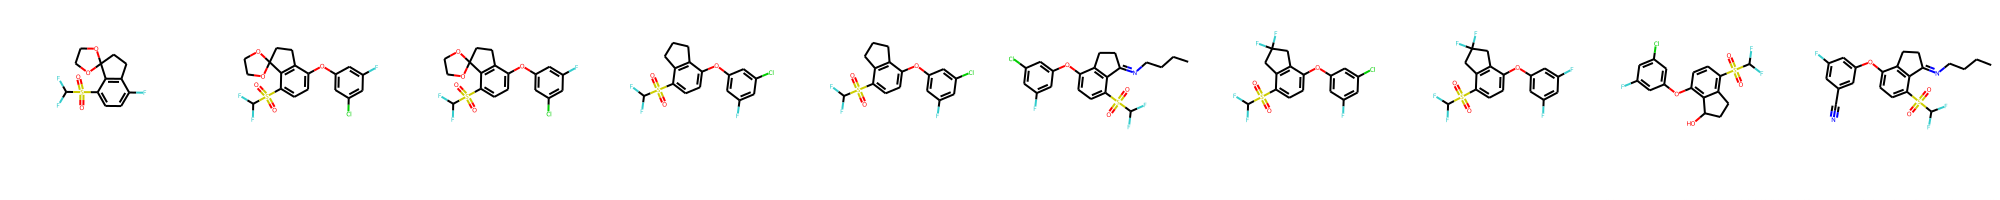

<< label 4 >>


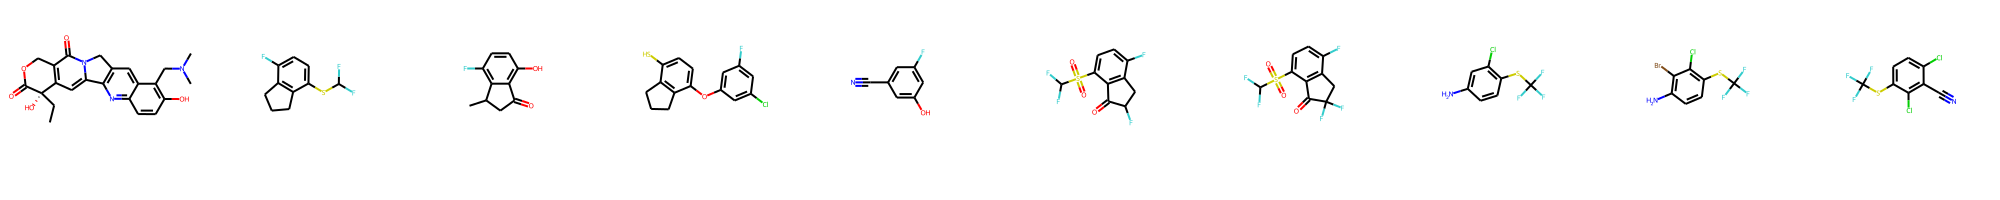

<< label 5 >>


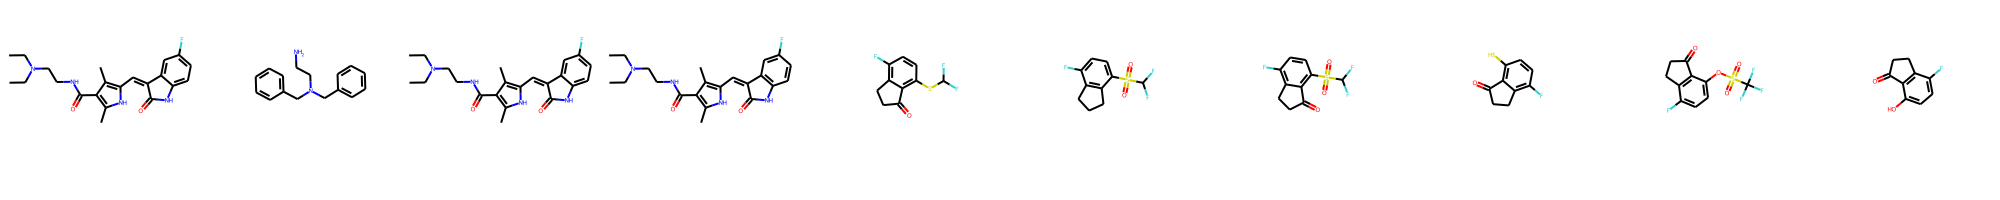

<< label 6 >>


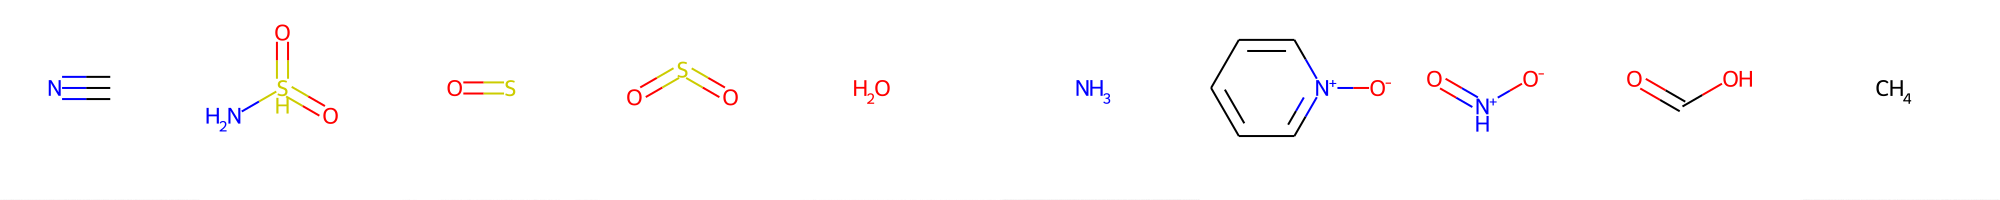

<< label 7 >>


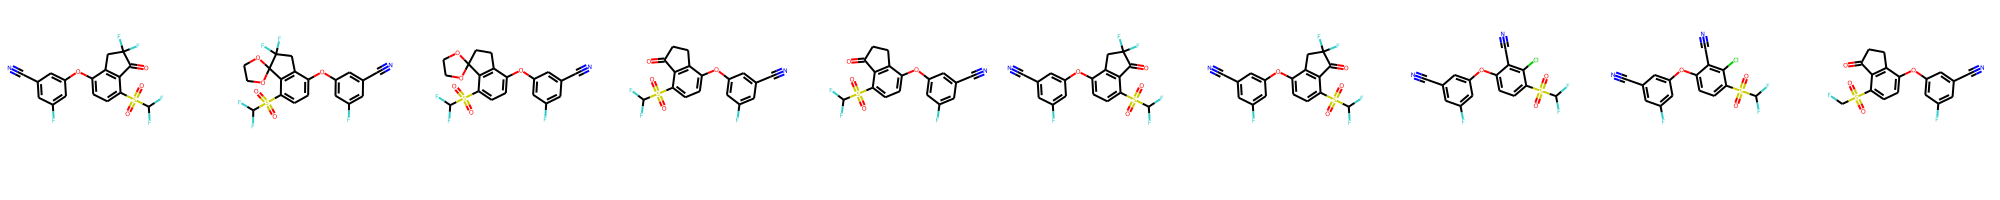

<< label 8 >>


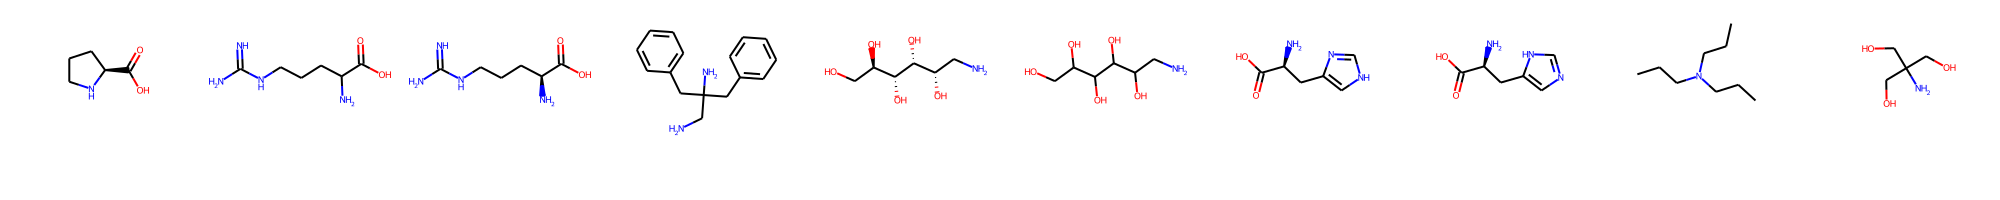

In [109]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
from rdkit.Chem import PandasTools

# Load index, smiles
df = pd.read_csv('./data/aryl_ether/index.csv')
index = df['0'].to_list()

df = pd.read_csv('./data/aryl_ether/aryl_ether.csv')
df['index'] = list(range(len(df)))
aryl_ether_smiles =  df[['index', 'annotation_reference', 'smiles']].values.tolist()
print('data fetched:', len(aryl_ether_smiles))

df = pd.DataFrame(points_latent_tsne)

n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df)
labels = kmeans.predict(df)
x = df[0]
y = df[1]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5, 5))
plt.scatter(x, y, c=labels, alpha=0.5, s=4)
plt.colorbar()
plt.show()

labels_area = [[], [], [], [], [], [], [], [], [], []]
for i in range(len(index)):
    labels_area[labels[i]].append(aryl_ether_smiles[index[i]])

df_area = []

for i in range(n_clusters):
    df_area.append(pd.DataFrame([], columns=[i]))

for i in range(len(index)):
    df_area[labels[i]] = pd.concat((df_area[labels[i]], pd.DataFrame([Chem.MolFromSmiles(aryl_ether_smiles[index[i]][2])], columns=[labels[i]])))

for label in range(n_clusters):
    print('<< label', label, '>>')
    display(PandasTools.FrameToGridImage(df_area[label][:10], column=label, legendsCol=label, molsPerRow=10))

## K means clustering - pattern tsne

data fetched: 1827


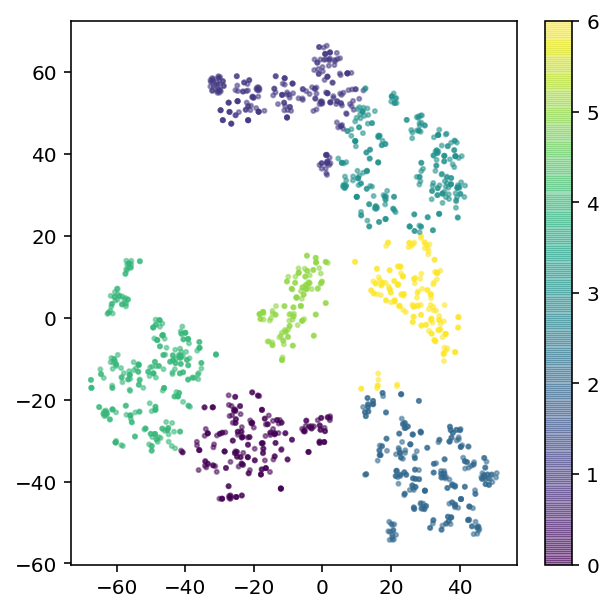

<< label 0 >>


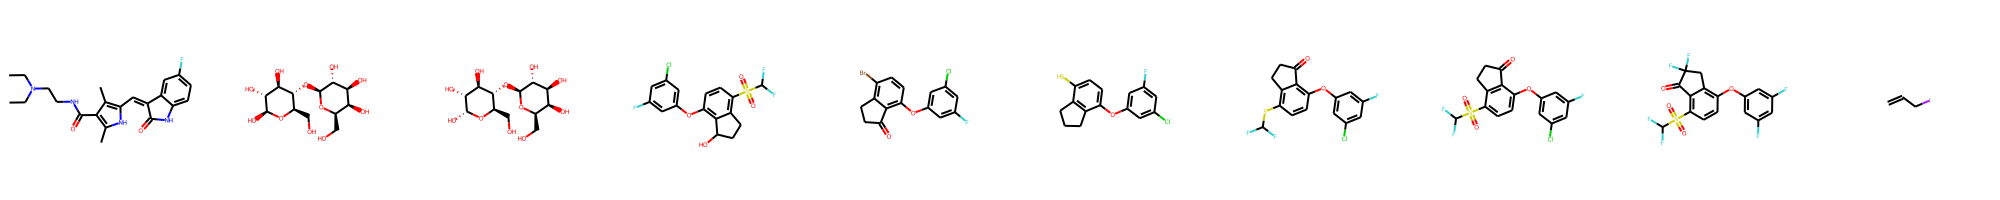

<< label 1 >>


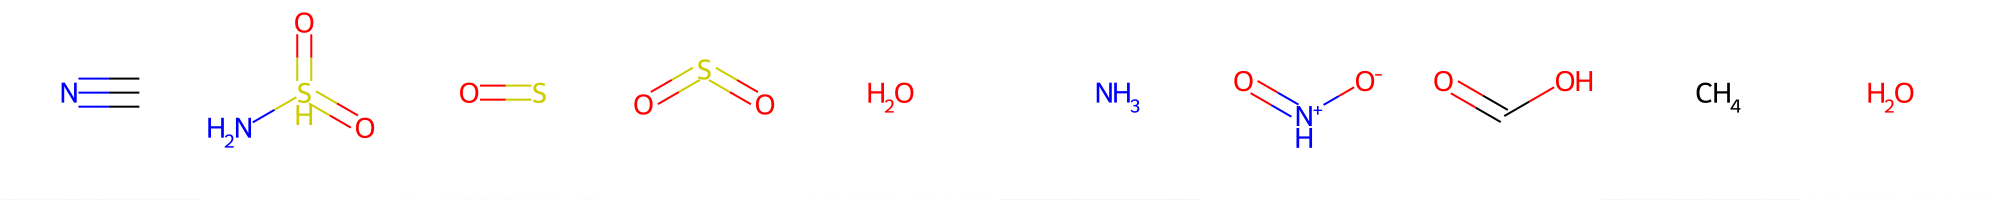

<< label 2 >>


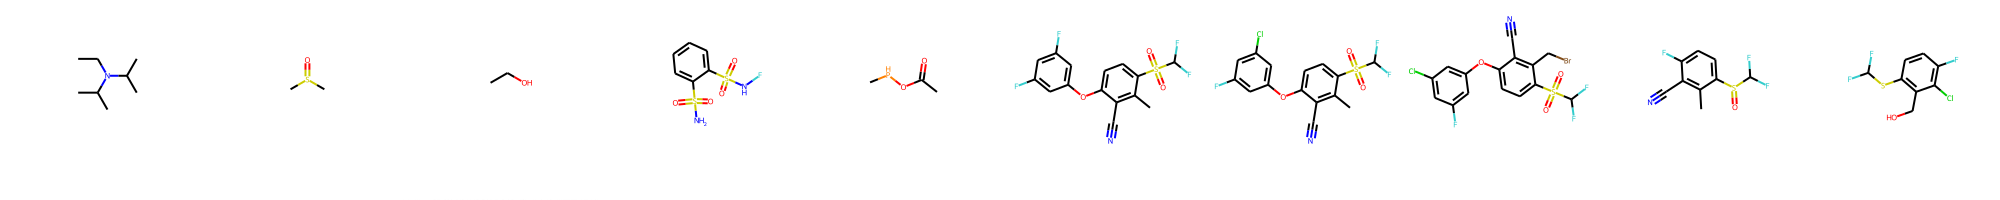

<< label 3 >>


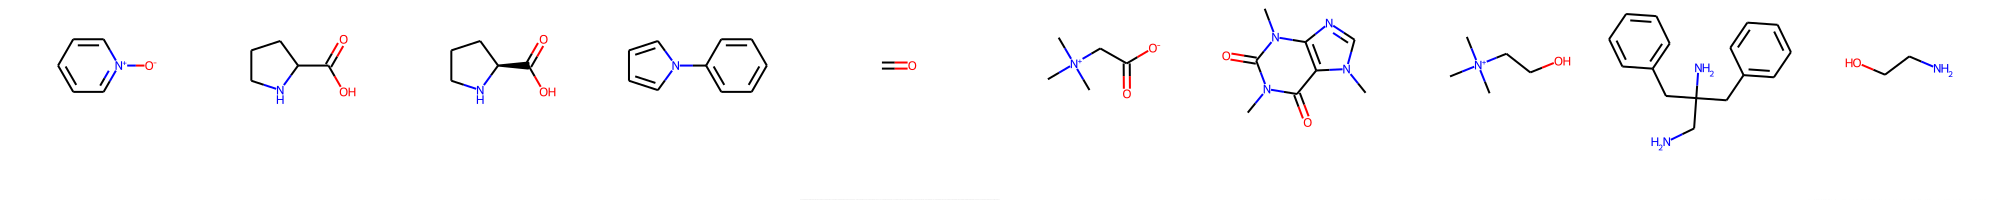

<< label 4 >>


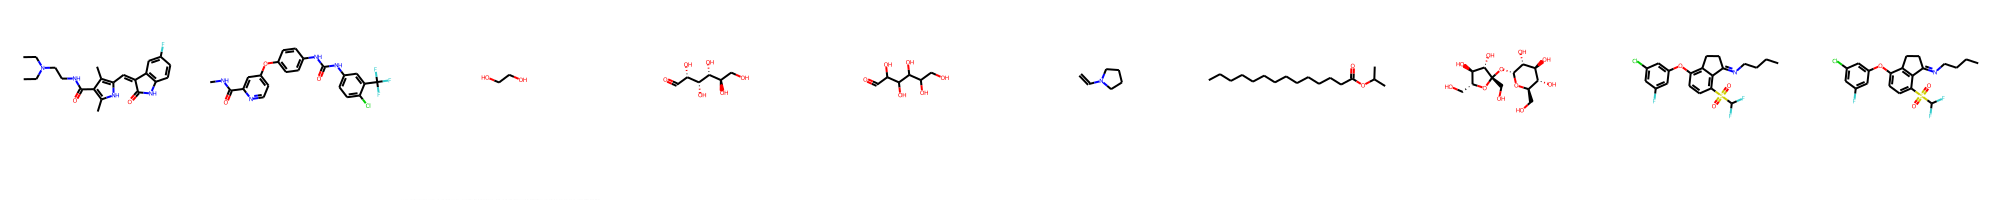

<< label 5 >>


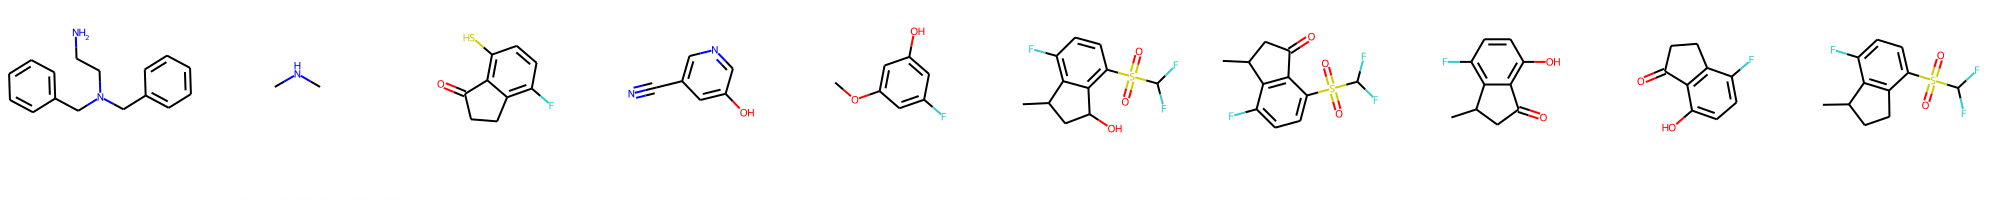

<< label 6 >>


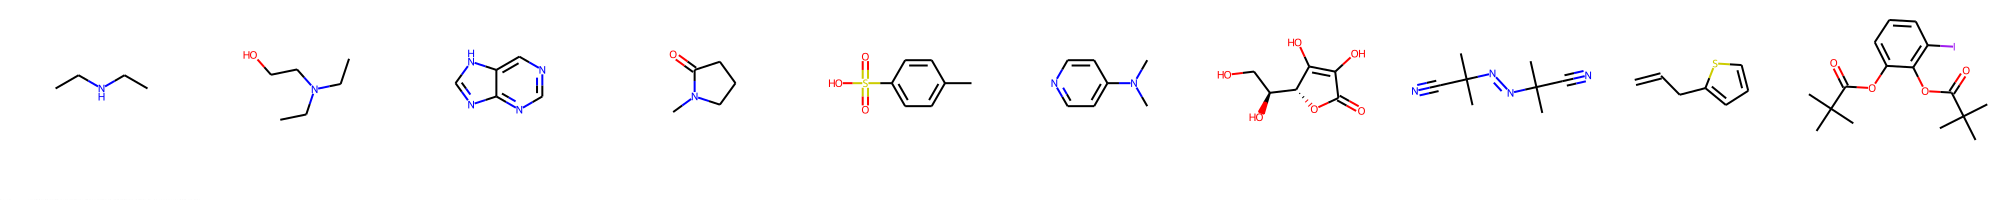

In [110]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
from rdkit.Chem import PandasTools

# Load index, smiles
df = pd.read_csv('./data/aryl_ether/index.csv')
index = df['0'].to_list()

df = pd.read_csv('./data/aryl_ether/aryl_ether.csv')
df['index'] = list(range(len(df)))
aryl_ether_smiles =  df[['index', 'annotation_reference', 'smiles']].values.tolist()
print('data fetched:', len(aryl_ether_smiles))

df = pd.DataFrame(points_pattern_fp_tsne)

n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df)
labels = kmeans.predict(df)
x = df[0]
y = df[1]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5, 5))
plt.scatter(x, y, c=labels, alpha=0.5, s=4)
plt.colorbar()
plt.show()

labels_area = [[], [], [], [], [], [], []]
for i in range(len(index)):
    labels_area[labels[i]].append(aryl_ether_smiles[index[i]])

df_area = []

for i in range(n_clusters):
    df_area.append(pd.DataFrame([], columns=[i]))

for i in range(len(index)):
    df_area[labels[i]] = pd.concat((df_area[labels[i]], pd.DataFrame([Chem.MolFromSmiles(aryl_ether_smiles[index[i]][2])], columns=[labels[i]])))

for label in range(n_clusters):
    print('<< label', label, '>>')
    display(PandasTools.FrameToGridImage(df_area[label][:10], column=label, legendsCol=label, molsPerRow=10))

## K means clustering - MACCSKeys tsne

data fetched: 1827


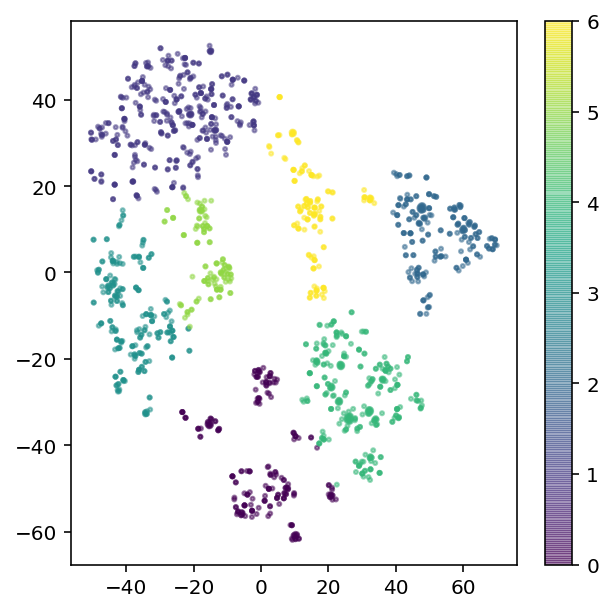

<< label 0 >>


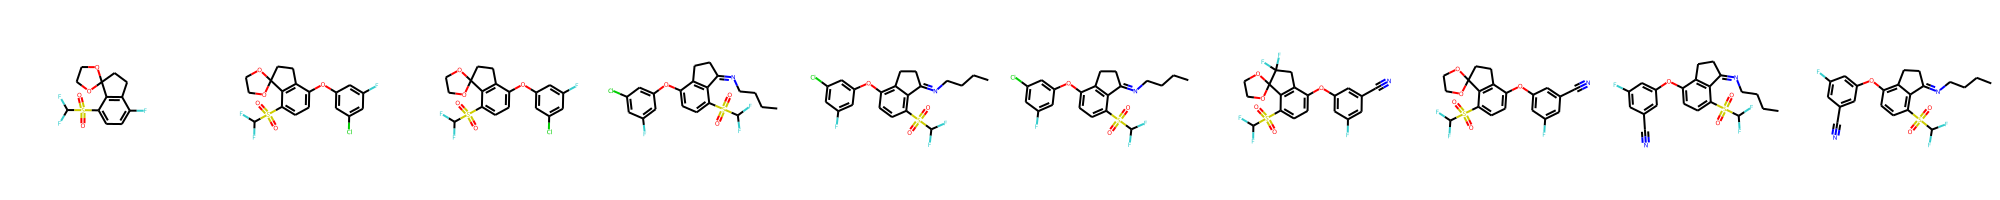

<< label 1 >>


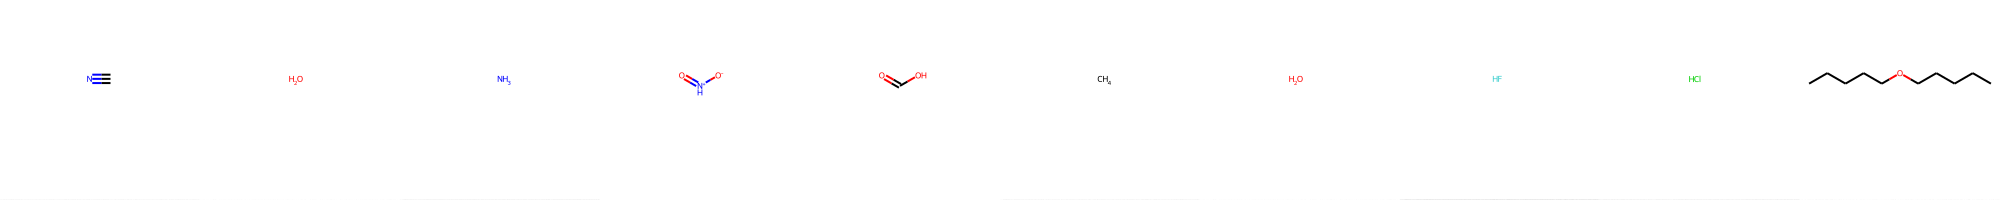

<< label 2 >>


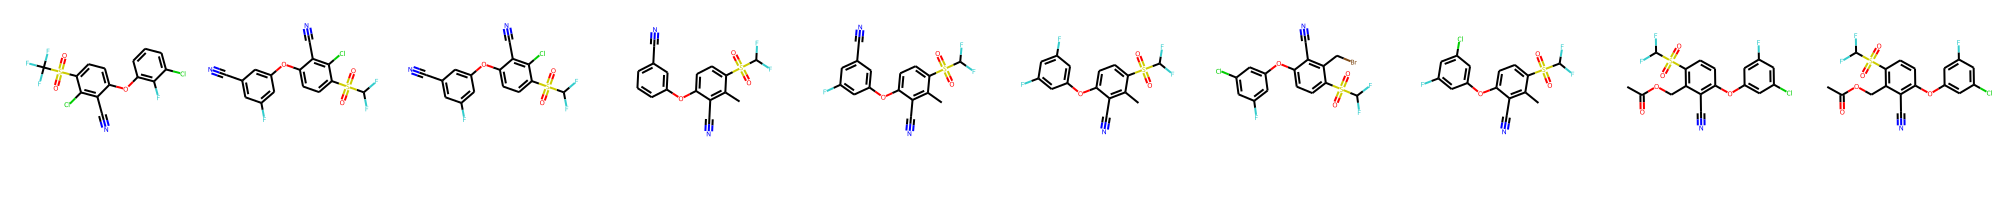

<< label 3 >>


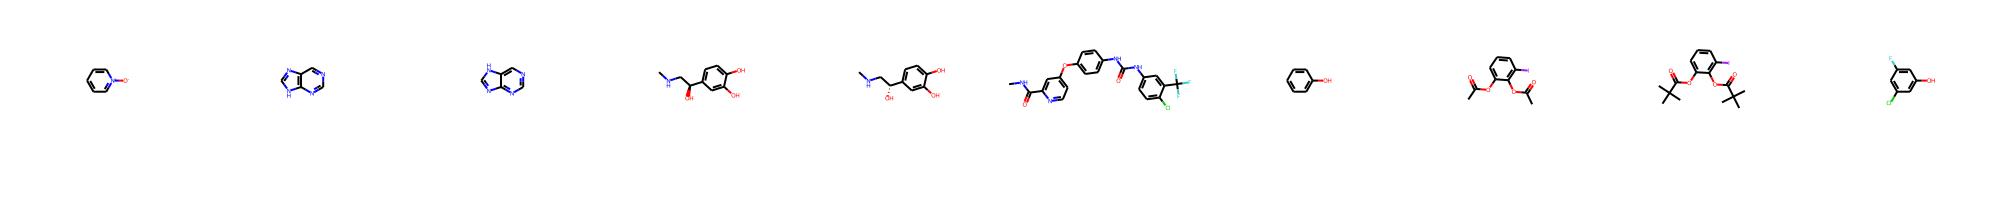

<< label 4 >>


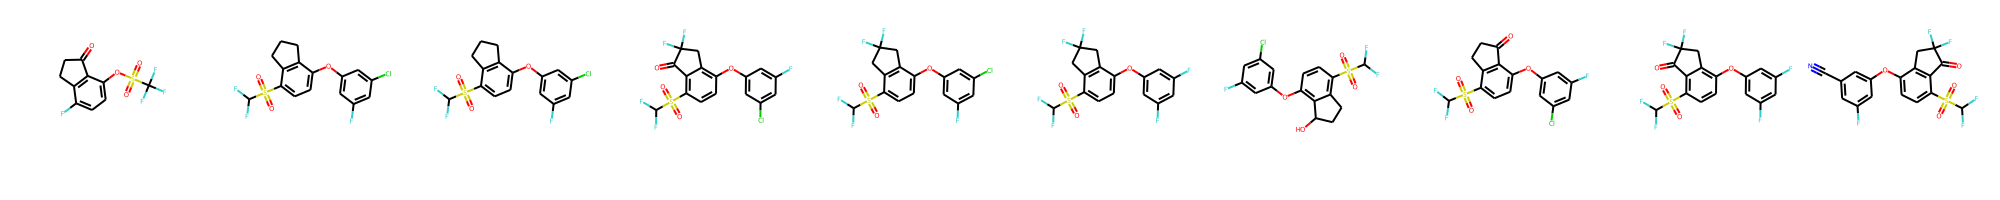

<< label 5 >>


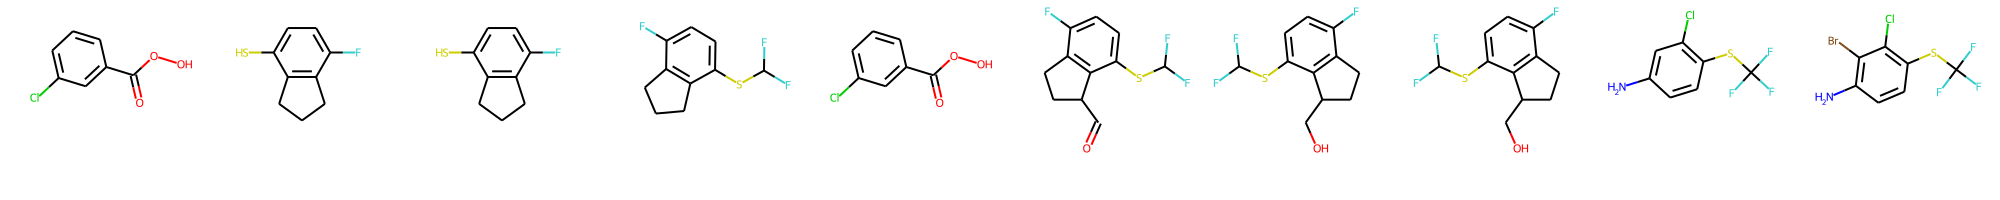

<< label 6 >>


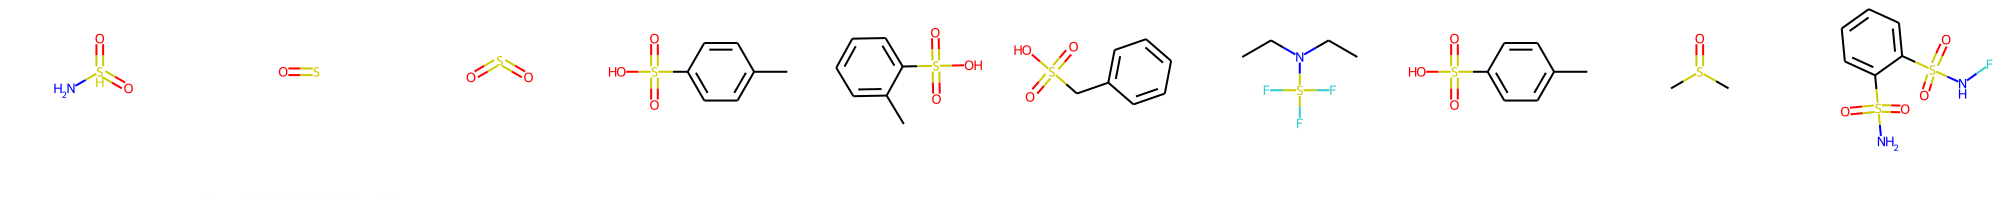

In [111]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
from rdkit.Chem import PandasTools

# Load index, smiles
df = pd.read_csv('./data/aryl_ether/fp_index.csv')
index = df['0'].to_list()

df = pd.read_csv('./data/aryl_ether/aryl_ether.csv')
df['index'] = list(range(len(df)))
aryl_ether_smiles =  df[['index', 'annotation_reference', 'smiles']].values.tolist()
print('data fetched:', len(aryl_ether_smiles))

df = pd.DataFrame(points_MACCSKeys_fp_tsne)

n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df)
labels = kmeans.predict(df)
x = df[0]
y = df[1]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((5, 5))
plt.scatter(x, y, c=labels, alpha=0.5, s=4)
plt.colorbar()
plt.show()

labels_area = [[], [], [], [], [], [], []]
for i in range(len(index)):
    labels_area[labels[i]].append(aryl_ether_smiles[index[i]])

df_area = []

for i in range(n_clusters):
    df_area.append(pd.DataFrame([], columns=[i]))

for i in range(len(index)):
    df_area[labels[i]] = pd.concat((df_area[labels[i]], pd.DataFrame([Chem.MolFromSmiles(aryl_ether_smiles[index[i]][2])], columns=[labels[i]])))

for label in range(n_clusters):
    print('<< label', label, '>>')
    display(PandasTools.FrameToGridImage(df_area[label][:10], column=label, legendsCol=label, molsPerRow=10))

## Save valid output in MACCSKeys tsne

In [116]:
valid_output = []

for i in range(len(index)):
    if labels[i] == 0 or labels[i] == 2 or labels[i] == 4:
        valid_output.append(aryl_ether_smiles[index[i]][2])

df = pd.DataFrame(valid_output)
df.to_csv('./data/aryl_ether/valid_output.csv')
print('save complete:', len(valid_output), 'molecules')

save complete: 728 molecules
